<a href="https://colab.research.google.com/github/Olofmeister007/Pytorch-exercise/blob/main/04_pytorch_custom_datasets_exercises_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.5.1+cu124


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/steak/730464.jpg
Image class: steak
Image height: 512
Image width: 512


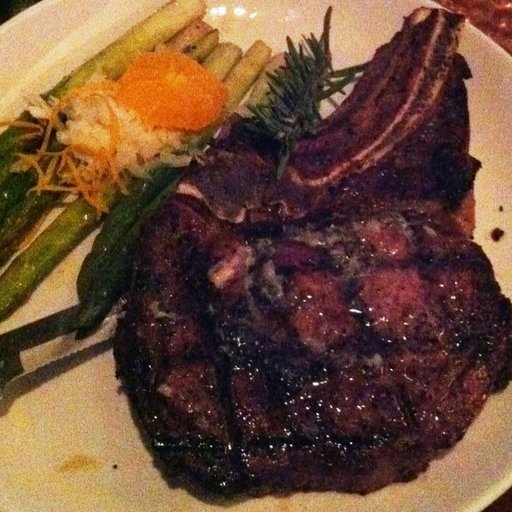

In [6]:
# Visualize an image
import random
from PIL import Image


image_path_list = list(image_path.glob("*/*/*.jpg"))
# print(image_path_list)
random_image_path = random.choice(image_path_list)
# print(random_image_path)

image_class = random_image_path.parent.stem
# print(image_class)

img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

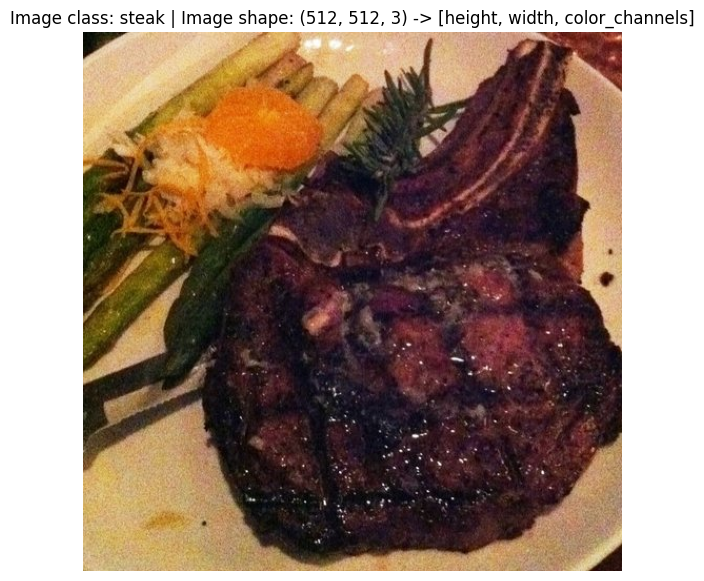

In [7]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.TrivialAugmentWide(31), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])


In [9]:
# # Write transform for turning images into tensors
# train_transform = data_transform(image_path_list)
# train_transform


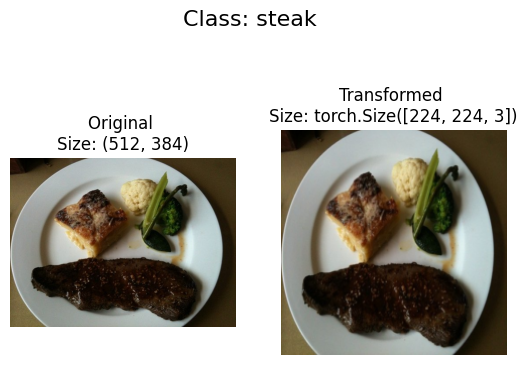

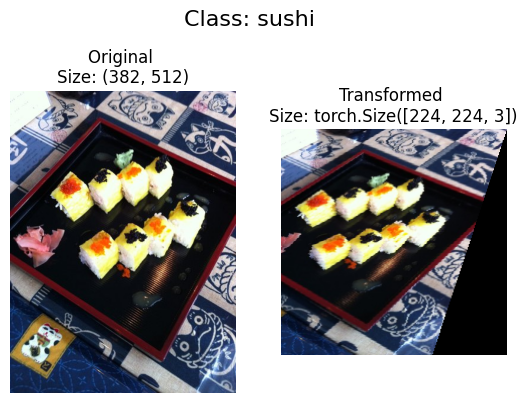

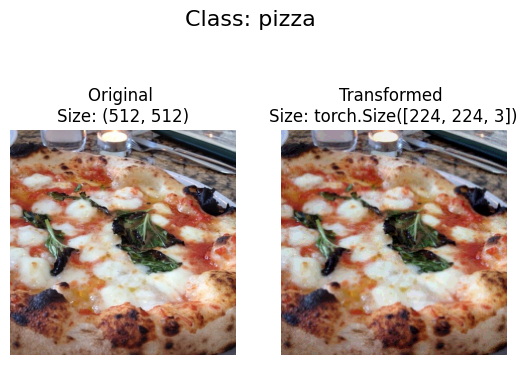

In [10]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):

   random_image_paths = random.sample(image_paths, k=n)
   for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)


### Load image data using `ImageFolder`

In [11]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(450, 150)

In [15]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1255, 0.1176, 0.1137],
         [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1176],
         [0.1216, 0.1255, 0.1216,  ..., 0.1098, 0.1176, 0.1137],
         ...,
         [0.1804, 0.1725, 0.1725,  ..., 0.0863, 0.0902, 0.0941],
         [0.1686, 0.1686, 0.1647,  ..., 0.0902, 0.0902, 0.0902],
         [0.1529, 0.1529, 0.1490,  ..., 0.0824, 0.0863, 0.0863]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.0824, 0.0745, 0.0706],
         [0.0588, 0.0627, 0.0627,  ..., 0.0706, 0.0706, 0.0745],
         [0.0627, 0.0667, 0.0627,  ..., 0.0667, 0.0784, 0.0706],
         ...,
         [0.2314, 0.2314, 0.7647,  ..., 0.1020, 0.1059, 0.1098],
         [0.2314, 0.2314, 0.2275,  ..., 0.1059, 0.1059, 0.1059],
         [0.2235, 0.2235, 0.2196,  ..., 0.0980, 0.1020, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.1059, 0.0980, 0.0941],
         [0.0196, 0.0235, 0.0235,  ..., 0.0941, 0.0941, 0.0980],
         [0.0196, 0.0235, 0.0235,  ..., 0.09

In [16]:
import os

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
import os

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
print(NUM_WORKERS)
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

train_dataloader, test_dataloader
train_dataloader, test_dataloader
image, label = next(iter(train_dataloader))



2


In [17]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)


(15, 5)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
class TinyVGG(nn.Module):
  def __init__(self, input_features, hidden_units, output_channels):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_features, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False)
        nn.Flatten(),
        nn.Linear(hidden_units * 56 * 56, output_channels)
    )

  def forward(self, x: torch.Tensor):
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # return x
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


model_0 = TinyVGG(input_features=3, hidden_units=20, output_channels=len(class_names)).to(device)


In [19]:
# test_input = torch.randn(3, 224, 224)
# test_input.shape
# test_input = test_input.unsqueeze(dim=0)
# test_input.shape

# model_0(test_input)

In [20]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 20, 224, 224]         560
│    └─ReLU: 2-2                         [1, 20, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 20, 224, 224]         3,620
│    └─ReLU: 2-4                         [1, 20, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 20, 112, 112]         --
├─Sequential: 1-2                        [1, 20, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 20, 112, 112]         3,620
│    └─ReLU: 2-7                         [1, 20, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 20, 112, 112]         3,620
│    └─ReLU: 2-9                         [1, 20, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 20, 56, 56]           --
├─Seq

## 4. Create training and testing functions for `model_0`.

In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [24]:
# # Train for 5 epochs
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # epochs = 5
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_0.parameters(),
#                              lr=0.001)

# train(model_0,train_dataloader,test_dataloader,optimizer,loss_fn, epochs=5)

In [25]:
# # Train for 20 epochs
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_0.parameters(),
#                              lr=0.001)

# train(model_0,train_dataloader,test_dataloader,optimizer,loss_fn, epochs=20)

In [26]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)
train(model_0,train_dataloader,test_dataloader,optimizer,loss_fn, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1443 | train_acc: 0.2917 | test_loss: 1.0777 | test_acc: 0.4460
Epoch: 2 | train_loss: 1.0617 | train_acc: 0.4437 | test_loss: 1.0330 | test_acc: 0.4381
Epoch: 3 | train_loss: 1.0053 | train_acc: 0.5000 | test_loss: 1.0320 | test_acc: 0.5023
Epoch: 4 | train_loss: 0.9011 | train_acc: 0.5729 | test_loss: 1.0057 | test_acc: 0.4676
Epoch: 5 | train_loss: 0.9371 | train_acc: 0.5563 | test_loss: 1.0229 | test_acc: 0.4403
Epoch: 6 | train_loss: 0.9859 | train_acc: 0.5312 | test_loss: 0.9407 | test_acc: 0.5426
Epoch: 7 | train_loss: 0.9356 | train_acc: 0.5292 | test_loss: 0.9942 | test_acc: 0.4682
Epoch: 8 | train_loss: 0.9014 | train_acc: 0.5604 | test_loss: 0.9808 | test_acc: 0.4489
Epoch: 9 | train_loss: 0.8935 | train_acc: 0.5854 | test_loss: 0.9884 | test_acc: 0.5040
Epoch: 10 | train_loss: 0.9004 | train_acc: 0.5687 | test_loss: 0.9718 | test_acc: 0.4898
Epoch: 11 | train_loss: 0.9380 | train_acc: 0.5104 | test_loss: 0.9185 | test_acc: 0.5511
Epoch: 12 | train_l

{'train_loss': [1.1443477153778077,
  1.0617295583089192,
  1.005333924293518,
  0.9010688026746114,
  0.9370560884475708,
  0.9859245737393697,
  0.9355902512868245,
  0.9014350295066833,
  0.8934852997461955,
  0.9004340211550395,
  0.9380066752433777,
  0.8813513437906901,
  0.9226331909497579,
  0.9365662217140198,
  0.8976624727249145,
  0.8634348630905151,
  0.8833041747411092,
  0.817283554871877,
  0.9179209669431051,
  0.8640477935473124,
  0.8132543245951335,
  0.8141287823518117,
  0.7633241693178813,
  0.8845064381758372,
  0.7663121938705444,
  0.7282583872477214,
  0.7630613446235657,
  0.6894195059935252,
  0.7557954629262288,
  0.7278838276863098,
  0.6206612686316172,
  0.6672940810521444,
  0.6760617196559906,
  0.7086701691150665,
  0.631795738140742,
  0.6293372690677643,
  0.5776967962582906,
  0.5673573354880015,
  0.6384380668401718,
  0.682809183994929,
  0.5826655109723409,
  0.6852272311846416,
  0.5552078699072202,
  0.5056490341822306,
  0.5919444859027863,


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [27]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [28]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [29]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images...

In [30]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [31]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [32]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [33]:
custom_image_path = data_path / "test_pizza.jpg"

In [36]:
import torchvision

# Read in custom image

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")



Custom image tensor:
tensor([[[0.4980, 0.5255, 0.5098,  ..., 0.4353, 0.4314, 0.4314],
         [0.5137, 0.5647, 0.5176,  ..., 0.4510, 0.4510, 0.4471],
         [0.4431, 0.5137, 0.5373,  ..., 0.4314, 0.4235, 0.4157],
         ...,
         [0.4118, 0.4000, 0.4275,  ..., 0.3804, 0.3765, 0.3569],
         [0.5098, 0.4745, 0.4863,  ..., 0.3451, 0.3412, 0.3255],
         [0.4078, 0.3804, 0.4588,  ..., 0.3529, 0.3451, 0.3216]],

        [[0.4510, 0.4784, 0.4510,  ..., 0.2667, 0.2627, 0.2627],
         [0.4667, 0.5176, 0.4588,  ..., 0.2824, 0.2824, 0.2784],
         [0.3843, 0.4549, 0.4784,  ..., 0.2627, 0.2549, 0.2471],
         ...,
         [0.2824, 0.2706, 0.2980,  ..., 0.2275, 0.2235, 0.2039],
         [0.3804, 0.3451, 0.3569,  ..., 0.1922, 0.1882, 0.1725],
         [0.2784, 0.2510, 0.3294,  ..., 0.2000, 0.1922, 0.1686]],

        [[0.3647, 0.3922, 0.3686,  ..., 0.0980, 0.0863, 0.0863],
         [0.3804, 0.4314, 0.3765,  ..., 0.1137, 0.1059, 0.1020],
         [0.2941, 0.3647, 0.3961,  ..

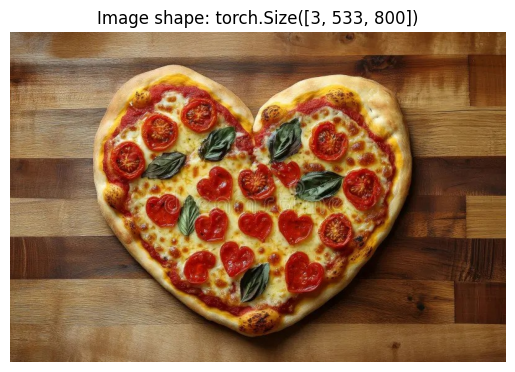

In [37]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [38]:
custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 533, 800])
New shape: torch.Size([3, 224, 224])


In [39]:
model_0.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [40]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.3432,  0.0454, -0.4134]])
Prediction probabilities: tensor([[0.2935, 0.4329, 0.2736]])
Prediction label: tensor([1])


In [41]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'steak'

In [45]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

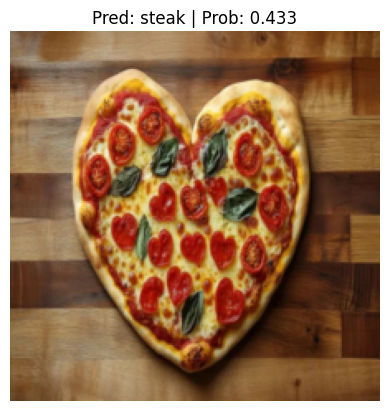

In [46]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)